In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from econml.policy import PolicyTree

In [3]:
import numpy as np

X = np.random.normal(size=(1000, 10))
y = np.hstack([X[:, [0]] > 0, X[:, [0]] < 0])

In [4]:
est = PolicyTree(min_impurity_decrease=.001, honest=True).fit(X, y)

In [5]:
est.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
from sklearn.tree import plot_tree

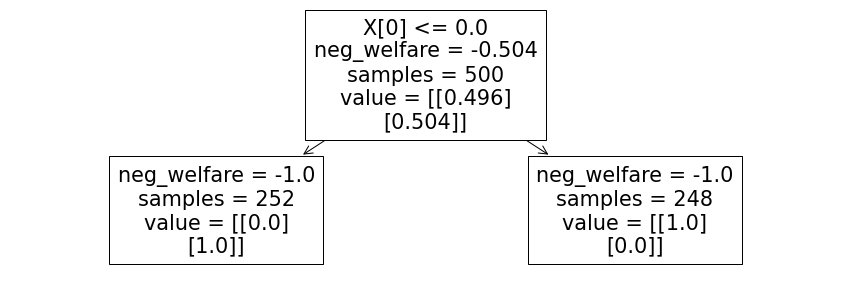

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plot_tree(est, max_depth=2)
plt.show()

In [8]:
from econml.policy import PolicyForest

est = PolicyForest(honest=True).fit(X, y)

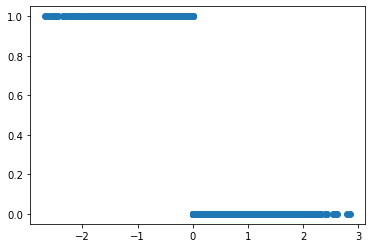

In [9]:
plt.scatter(X[:, 0], est.predict(X))
plt.show()

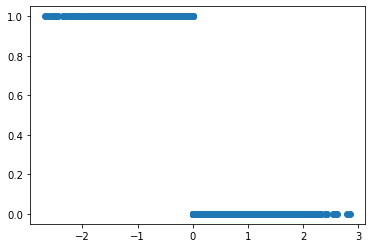

In [10]:
plt.scatter(X[:, 0], est.predict(X))
plt.show()

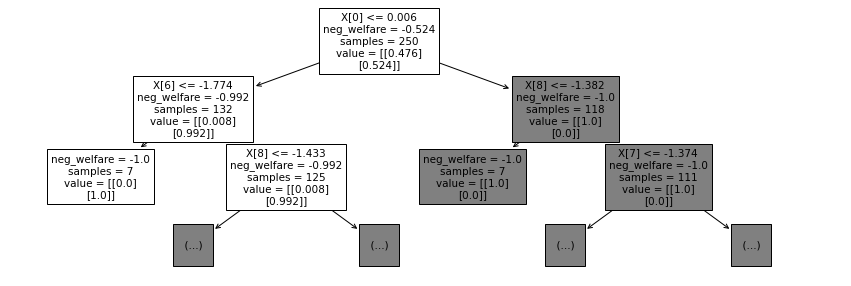

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plot_tree(est[0], max_depth=2)
plt.show()

In [12]:
est.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [105]:
import numpy as np

X = np.random.normal(size=(1000, 10))
T = np.random.binomial(2, .5, size=(1000,))
y = (X[:, 0]) * (T==1) + (-X[:, 0]) * (T==2) 

In [79]:
from econml.dml import LinearDML
est = LinearDML(discrete_treatment=True, linear_first_stages=False).fit(y, T, X=X)

In [101]:
intrp = SingleTreePolicyInterpreter(max_depth=2, min_impurity_decrease=.001)
intrp.interpret(est, X,
                sample_treatment_costs=.2 * np.ones((X.shape[0], 2)),
                treatment_names=['A', 'B'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


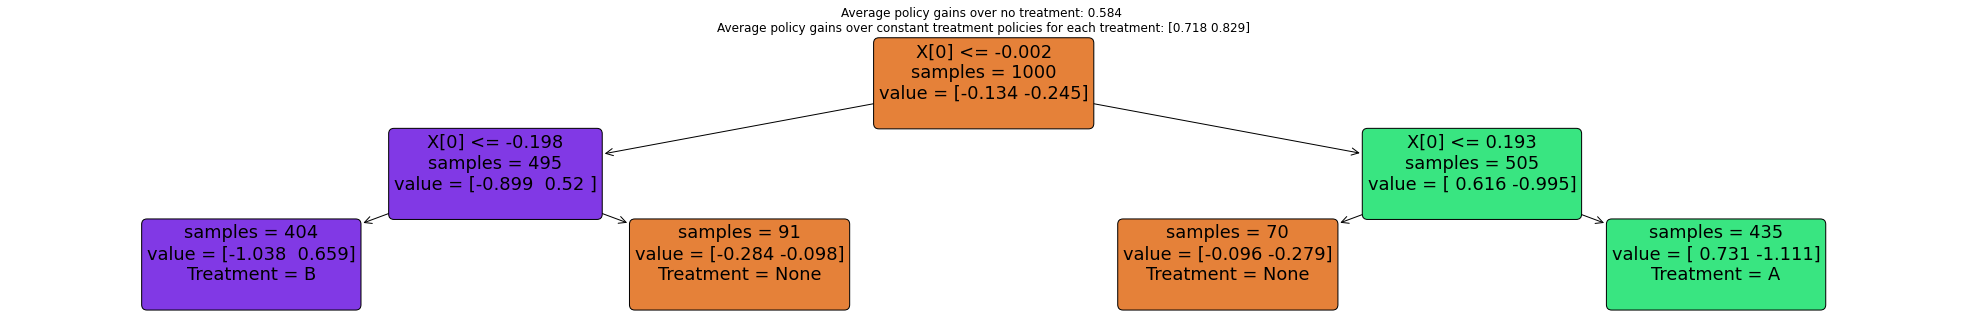

In [104]:
plt.figure(figsize=(35,5))
intrp.plot()
plt.show()